In [1]:
%pylab inline
import shgsvd
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=2)
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_yeast = pd.read_table('../PNAS_2000_datasets/Yeast.txt', header=1)
df_yeast= df_yeast.loc[:, '0_min':]
df_yeast = df_yeast.replace('Null', np.nan)
df_yeast = df_yeast.astype(float)

In [3]:
df_human = pd.read_table('../PNAS_2000_datasets/Human.txt', header=1)
df_human = df_human.loc[:, '2_hr':]
df_human = df_human.replace('Null', np.nan)
df_human = df_human.astype(float)

In [ ]:
def SVD_impute(df):
    """Perform SVD imputing.
    
    
    Parameters
    ----------
    matrix: array_like
            Array with rows as genes and columns as tissues/samples
            with nans for missing values
    
    Returns
    -------
    filled_matrix: array_like
                   Imputed matrix with entries filled by relying on eigengenes    
    """
    
    null_idx = pd.isnull(df).any(1).nonzero()[0]

    full_matrix = df.values
    non_null_matrix  = df.dropna().values
    U, S, V_T = np.linalg.svd(non_null_matrix)
    V =  V_T.T
    
    for index in null_idx:
        x = full_matrix[index,:]

        # index of entries where the row is nan
        row_na_idx = np.where(np.isnan(x))
        
        # index of entries where the row is not nan        
        row_not_na_idx = np.where(~np.isnan(x))
        
        
        # entries from row which are not nan        
        x_star_not_na = x[row_not_na_idx]
        
         # entries from row which are not nan        
        x_star_na = x[row_na_idx]

        # Eigen genes corresponding to index 
        # of locations (columns) in row x which are nan
        V_star_na = np.delete(V, row_not_na_idx, 0)
        
        
        # Delete rows from V, corresponding to index 
        # of locations (columns) in row x which are nan
        # We will use these to project the row with complete
        V_star_not_na = np.delete(V, row_na_idx, 0)


        gram = np.dot(V_star_not_na.T, V_star_not_na)
        coeff = np.dot(np.linalg.pinv(gram), V_star_not_na.T)

        beta = np.dot(coeff, x_star_not_na)
        
        # xhat = V_J \beta
        x_missing = np.dot(V_star_na, beta)
        
        # Fill in the missing entries
        full_matrix[index, row_na_idx] = x_missing
    return full_matrix

In [11]:
df_yeast.dropna().shape

(2698, 18)

In [12]:
df_human.dropna().shape

(4360, 18)

In [13]:
u.shape

(2698, 2698)

In [14]:
q.shape

(18, 18)

In [15]:
a.shape

(2698, 18)

In [4]:
a, b, alpha, beta, u, v, q = shgsvd.gsvd(df_yeast.dropna().values, df_human.dropna().values)
#a, b, alpha, beta, u, v, q = shgsvd.gsvd(SVD_impute(df_yeast), SVD_impute(df_human))

In [10]:
u.shape

(2698, 2698)

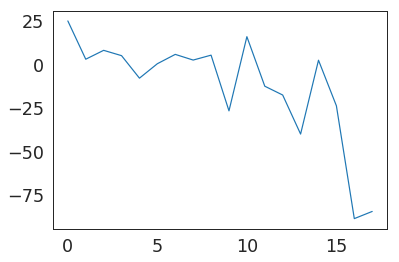

In [16]:
plt.plot(a[0, :])

In [5]:
alpha

array([0.96635544, 0.7896719 , 0.97944003, 0.88035464, 0.65733516,
       0.8134823 , 0.44418156, 0.31634256, 0.5035491 , 0.12115929,
       0.6339678 , 0.555556  , 0.35075137, 0.83218586, 0.47422588,
       0.7357883 , 0.59820527, 0.7032445 ], dtype=float32)

In [6]:
beta

array([0.25721014, 0.6135294 , 0.20173584, 0.47431597, 0.7535984 ,
       0.5815898 , 0.8959368 , 0.948645  , 0.8639666 , 0.9926331 ,
       0.7733594 , 0.83147913, 0.93646866, 0.55449677, 0.8804032 ,
       0.6772116 , 0.8013429 , 0.710948  ], dtype=float32)

0.39269908169872414

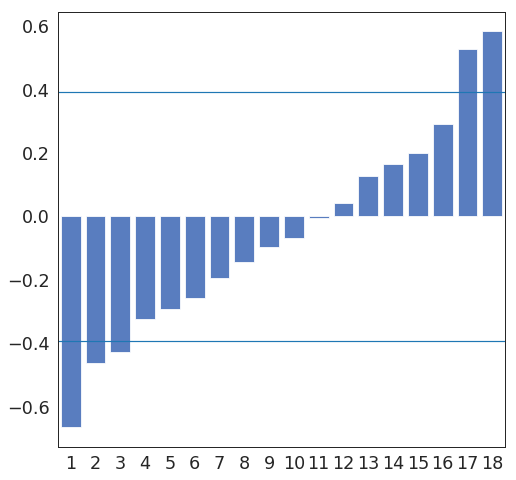

In [49]:
a, b, alpha, beta, u, v, q = shgsvd.gsvd(df_yeast.dropna().values, df_human.dropna().values)

angles = np.arctan2(alpha, beta) - np.pi/4
fig, ax = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")

sns.barplot(x=np.arange(1, len(angles)+1), y=sorted(angles), ax=ax, color="b")
ax.axhline(y=np.pi/8)
ax.axhline(y=-np.pi/8)
#ax.set_ylim(-np.pi/4, np.pi/4)

np.pi/8

In [44]:
angles

array([-0.7853982 , -0.630997  , -0.16808498,  0.7853982 ,  0.7853982 ],
      dtype=float32)

In [ ]:
alpha

In [ ]:
beta

In [ ]:
a

In [24]:
def einsum_row_norm(a):
    return np.sqrt(np.einsum('ij,ij->i', a, a))

def einsum_col_norm(a):
    return np.sqrt(np.einsum('ij,ij->j', a, a))


def ho_SVD(list_of_X):
    """ Perform higher order SVD
    
    list_of_X: list
               [X_1, X_2, X_3, ..., X_n] size (n x m)
    
    """
    # Step 1
    # A_i = X_i^T X_i
    # A_inv = moore_penrose_inv(A_i)
    A = []
    N = len(list_of_X)
    A_inv = []
    for X in list_of_X:
        A_i = np.dot(X.T, X)
        A.append(A_i)
        A_inv.append(np.linalg.pinv((A_i)))
    # Step 2
    # W = 1/N(N-1) * sum_{i=1}^jn sum_{j>i}^N A_i moore_penrose_inv(A_j) + A_j moore_penrose_inv(A_i)
    W = 0
    
    for i in range(N):
        for j in range(i+1, N):
            W = W + (np.dot(A[i], A_inv[j]) + np.dot(A[j], A_inv[i]))
    W =  W/(N*(N-1))
    
    # Step 3
    # Eigen decomposition of W?
    # WV = V\Lambda
    # V= (v_1, v_2, ..., v_n)
    # ||v||_k =1, but V is not necesarrily orthonormal
    # But we don't
    
    eigen_values, V = eig(W)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    V = V[:,idx]
    
    
    # Step 4
    # solve for  VB_i = X_i^T
     #Calculate the Bi matrices
   
    B = []
    U = []
    sigmas = []
    for X in list_of_X:
        #B_i = spams.omp( np.asfortranarray(X.T), V, lambda1=0, numThreads = 24)]
        # VB.T = X.T
        B_i = np.dot(np.linalg.inv(V), X.T).T
        B.append(B_i)
        sigma_i  = np.linalg.norm(B_i, axis=0) #einsum_col_norm(B)
        U_i = B_i/sigma_i 
        sigmas.append(sigma_i)
        U.append(U_i)
    return U, sigmas, V
    

In [17]:
A = np.array([[1, 2, 3, 1, 5],
              [0, 3, 2, 0, 2],
              [1, 0, 2, 1, 0],
              [0, 2, 3, 0, -1],
              [1, 0, 2, 1, 1],
              [0, 2, 1, 0, 1]])


B = np.array([[1, -2, 2, 1, 1],
              [0, 3, 0, 0, 0],
              [1, -2, 2, 1, 1],
              [0, 2, 0, 0, 0],
              [2, -4, 4, 2, 2],
              [1, 3, 2, 1, 1]])




In [39]:
def calcHOGSVD(matList):
    #assert len(matList)==3
    #Step 1: calculate Di^T*Di
    aMat = list()
    sMat = list()
    N = len(matList)
    for mat in matList:
        D = mat
        aMatTemp = np.dot(D.T, D)
        aMat.append(aMatTemp)

    #calculate pairwise Sij sums
    for i in range(len(aMat)):
        for j in range(i + 1, len(aMat)):
            print(i, j)
            sMatTemp = 0.5 * (np.dot(aMat[i], np.linalg.pinv(aMat[j])) + np.dot(
                aMat[j], np.linalg.pinv(aMat[i])))
            sMat.append(sMatTemp)

    S = np.zeros(sMat[0].shape)

    #sum all Si,j matrices to get S
    for s in sMat:
        S = S + s

    #normalize S
    S = (2.0 / (N * (N - 1))) * S

    #Do the eigen-decomposition on S
    L, V = np.linalg.eig(S)

    #Calculate the Bi matrices
    bMatList = list()
    for mat in matList:
        D = mat
        BT = np.dot(np.linalg.inv(V), D.T)
        bMatList.append(BT.T)

    #from Bi matrices calculate U and Sigma matrices
    sigList = list()
    uMatList = list()

    for B in bMatList:
        sig = np.sqrt(np.sum(B * B, axis=0))
        U = B / sig
        SIG = np.diag(sig)
        sigList.append(SIG)
        uMatList.append(U)

    return (uMatList, sigList, V)

In [40]:
#U, sigmas, V =  ho_SVD([A,B])
U, sigmas, V =  calcHOGSVD([A,B])

0 1


In [41]:
sigmas

[array([[1.20350819e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 7.33410530e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.51460016e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36606279e-13,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         3.79220949e+00]]),
 array([[7.73261848e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 8.25674763e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.82221336e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.43213773e-15,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         8.86884725e-02]])]

In [28]:
angles

array([[-0.6309965 , -0.78539816, -0.78539816, -0.78539816, -0.78539816],
       [-0.78539816, -0.0591095 , -0.78539816, -0.78539816, -0.78539816],
       [-0.78539816, -0.78539816,  0.08286157, -0.78539816, -0.78539816],
       [-0.78539816, -0.78539816, -0.78539816,  0.76201541, -0.78539816],
       [-0.78539816, -0.78539816, -0.78539816, -0.78539816,  0.7633225 ]])

(-0.7853981633974483, 0.7853981633974483)

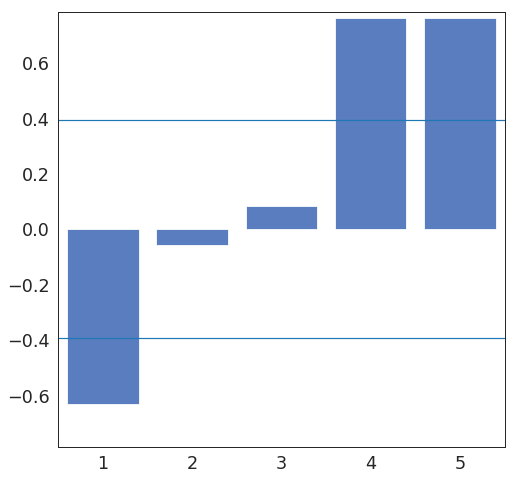

In [30]:
angles = np.arctan2(sigmas[0], sigmas[1]) - np.pi/4
fig, ax = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")

sns.barplot(x=np.arange(1, len(angles)+1), y=angles, ax=ax, color="b")
ax.axhline(y=np.pi/8)
ax.axhline(y=-np.pi/8)
ax.set_ylim(-np.pi/4, np.pi/4)

In [20]:
alpha

array([1.        , 1.        , 0.15378843, 0.57884634, 0.        ],
      dtype=float32)

In [21]:
beta

array([0.       , 0.       , 0.9881038, 0.8154366, 0.       ],
      dtype=float32)

In [31]:
sigmas[0]

array([1.20350819e+00, 7.33410530e+00, 4.51460016e+00, 3.79220949e+00,
       1.37786175e-13])

In [32]:
sigmas[1]

array([7.73261848e+00, 8.25674763e+00, 3.82221336e+00, 8.86884725e-02,
       3.04221513e-15])

In [50]:
A = np.array([[1, 2, 3, 1, 5],
              [0, 3, 2, 0, 2],
              [1, 0, 2, 1, 0],
              [0, 2, 3, 0, -1],
              [1, 0, 2, 1, 1],
              [0, 2, 1, 0, 1]])


B = np.array([[1, -2, 2, 1, 1],
              [0, 3, 0, 0, 0],
              [1, -2, 2, 1, 1],
              [0, 2, 0, 0, 0],
              [2, -4, 4, 2, 2],
              [1, 3, 2, 1, 1]])

In [51]:
a, b, alpha, beta, u, v, q = shgsvd.gsvd(A, B)

In [52]:
alpha

array([1.        , 1.        , 0.15378843, 0.57884634, 0.        ],
      dtype=float32)

In [53]:
beta

array([0.       , 0.       , 0.9881038, 0.8154366, 0.       ],
      dtype=float32)